# Explaining boosting on reweighting problem of high dimensional data

Tatiana Likhomanenko, Alex Rogozhnikov, November 2016

This notebook consist of several parts:

* Neural network parameters: demonstration how these parameters influence reweighting rule
* Variance and bias errors discussion
* BDT reweighter tuning (introduction to reweighting problem can be found in the [post](http://arogozhnikov.github.io/2015/10/09/gradient-boosted-reweighter.html))
* Reweighting problem for sPlot data, when weights (that can be negative) are defined for target distribution.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy
from scipy.stats import chi2

In [2]:
import sys
sys.path.insert(0, '.')

In [3]:
import pandas
from utils import draw_distributions, plot_roc, check_reweighting_by_ML_gb
from utils import reconstruct_ratio_using_estimated_pdfs, reconstruct_weights_by_GBreweighter
from utils import reconstruct_weights_by_GBreweighter_with_blow_up

from sklearn.cross_validation import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

# BDT reweighter
from hep_ml.reweight import GBReweighter

# for calibration
from sklearn.model_selection import StratifiedShuffleSplit
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Toy samples description

In this part we reuse the toy distributions used in the [notebook](https://github.com/cranmer/carl-notebooks/blob/master/reweighing-high-dimensional-data.ipynb):


* Generate 5 independent variables: 
    * two Gaussian $\mathcal{N}(\alpha, 1)$ and $\mathcal{N}(\beta, 3)$
    * mixture of two Gaussians $\mathcal{N}(-2, 1)$ and $\mathcal{N}(2, 0.5)$
    * two exponential with means $3$ and $5$.
* Two Gaussian have different means for original and target distributions: original with $\alpha=1, \beta=-1$, target with $\alpha=0, \beta=0$.

## Toy samples options:
* option `with_linear_transformation`: apply linear transformation to generated 5 variables (`with_linear_transformation=True`). 
* option `add_variation`: add random values in variance to obtain gaussian pdf for original and target samples not only with different mean but also with different variance (`add_variation=True`). 
When gaussian distributions have same variance for original and target distributions, logarithm of weights is simply linear function, that's what we'll see later.


## 1.Tuning of NN parameters

The following parameters are considered:
* optimization algorithm
* number of layers
* activation functions
* calibration of $p_0(x)$ and $p_1(x)$

Tuning of parameters is demonstrated on the reweighting rule based on [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273), where reconstruction of calibrated $p_0(x)$ and $p_1(x)$ is done and then its ratio is taken as a weight estimate. The quality of these probability density functions reconstruction influence on reweighting rule quality. Neural network is used to estimate $p_0(x)$ and $p_1(x)$.

Toy samples are generated for which initial distributions are known. Thus exact weights are known and we can compare them with those obtained after reweighting procedure.

### Special case of samples

Take toy samples with linear transformation. Let's check that simple neural network with one neuron (= zero hidden layers) can compute probabilities perfectly. Thus the weights can be reconstructed exactly as the ratio of predicted probabilities.

### Look at different optimization procedures

Optimization procedure depends on samples, thus results can be different for different algorithms on different samples.

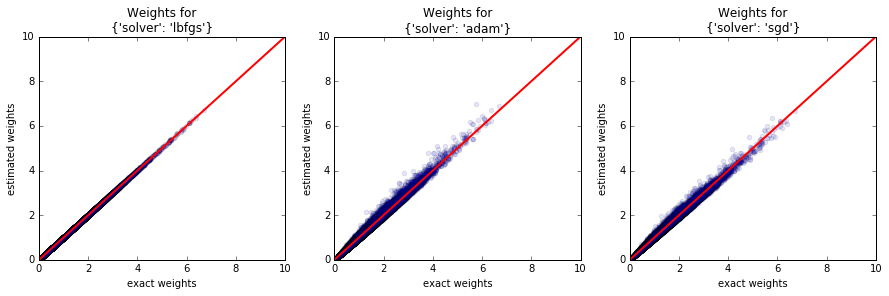

In [4]:
base_nn = MLPClassifier(
    tol=1e-05, activation="logistic", learning_rate_init=1e-3,
    learning_rate="constant", random_state=42, hidden_layer_sizes=(),
    max_iter=100)
nn_params = [{'solver': 'lbfgs'}, {'solver': 'adam'}, {'solver': 'sgd'}]
reconstruct_ratio_using_estimated_pdfs(
    base_nn, nn_params,
    with_linear_transformation=True, verbose=False)

**Important**: NN with one neuron (=no hidden layers) can easily reconstruct exact weights due to the way original distributions defined.

### Try to reconstruct linear rule using non-linear rule

If our assumption for true decision rule is not correct then reconstruction, of course, will be much worse.

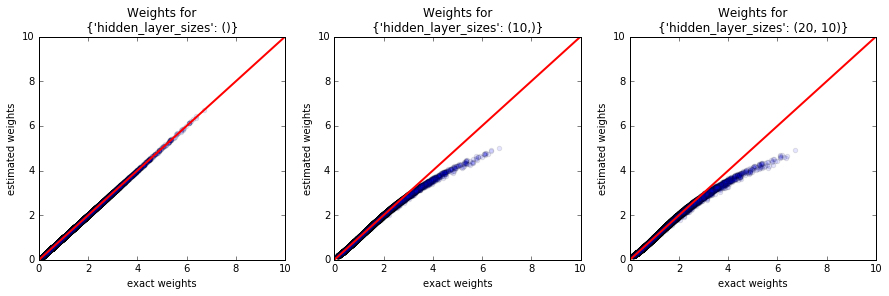

In [5]:
base_nn = MLPClassifier(
    tol=1e-05, activation="logistic", solver='lbfgs',
    random_state=42, hidden_layer_sizes=(), max_iter=100)
nn_params = [{'hidden_layer_sizes': ()}, {'hidden_layer_sizes': (10, )}, 
             {'hidden_layer_sizes': (20, 10)}]
reconstruct_ratio_using_estimated_pdfs(
    base_nn, nn_params,
    with_linear_transformation=True, verbose=False)

#### Summary:
* the behavior of NN is hard to predict when varying different parameters
* you can play with other parameters and see that NN parameters tuning is some sort of art.

### Define different activation functions

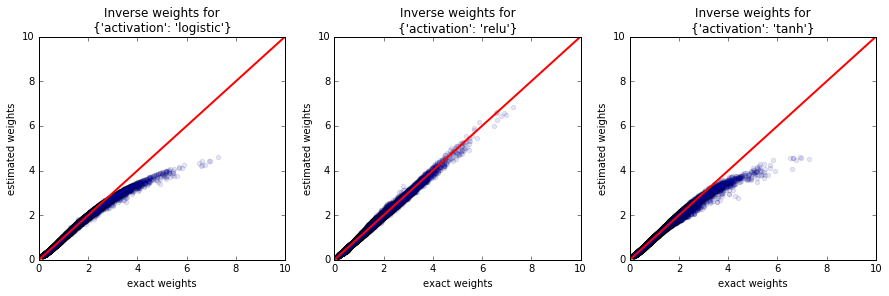

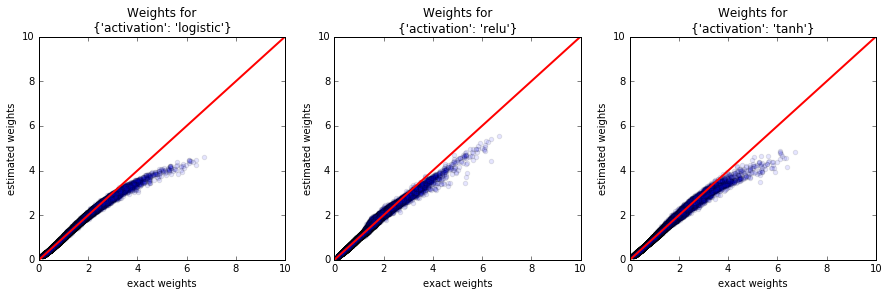

In [6]:
base_nn = MLPClassifier(
    tol=1e-05, hidden_layer_sizes=(10, 10), solver='lbfgs',
    random_state=42, max_iter=100)
nn_params = [{'activation': 'logistic'}, 
             {'activation': 'relu'}, {'activation': 'tanh'}]
reconstruct_ratio_using_estimated_pdfs(
    base_nn, nn_params, with_linear_transformation=True, 
    verbose=False, inverse_weights=True)

For classification regions with small weights and regions with high weights are equally (un)important because in these regions class probability is predicted with small error: on plots with weights and inverse weights we see deviation from the diagonal (classification loss function is the same for weights and inverse weights). However, for reweighting we are interested in $\sum_i (w_i - \hat{w}_i)^2\to\min$, so regions with high weights are of serious interest.  Let's look at the connection between reweighting problem and classification problem.

$$w(x) = \frac{p_1(x)}{p_0(x)} = \frac{p_1(x)}{1 - p_1(x)} = \frac{p(x)}{1 - p(x)}$$ 

$$\frac{\partial{w}}{\partial{p}} = \frac{1}{(1 - p)^2},$$

then we can find the dependence between probability error and weight error:

$$\Delta w = \frac{\Delta p}{(1 - p)^2}.$$

This means that for $p\sim 1$ small error for classification provides huge error for reweighting (regions where weights are large). And we see this effect in the deviation from the diagonal (**bias**) for large weights regions.

## 2. Bias and Variance

Thus we can consider two errors types: bias and variance. 

* **Bias** can be considered as some sort of **systematic error** of our reweighter. In practice, this error with different degree of success can be fixed by parameters tuning and finding more accurate approximating model for exact reweighting rule. This systematic error can significantly influence reweighting quality of the test samples. As discussed above, bias is observed for large weights regions due to huge coefficient between classification error and reweighting error.

* **Variance** can be considered as **statistical error** in the following manner: when trained reweighting rule is applied to the large test samples the variance contribution becomes smaller.

### Bias study: model tuning

Use different variance for Gaussian generated distributions, thus original and target distributions are not "linearly discriminated". Bias appears for the linear decision rule and by tuning model we can make it smaller (to some limit). The problem is that we don't solve reweighting problem directly and weights estimation strongly depends on probabilities reconstruction.

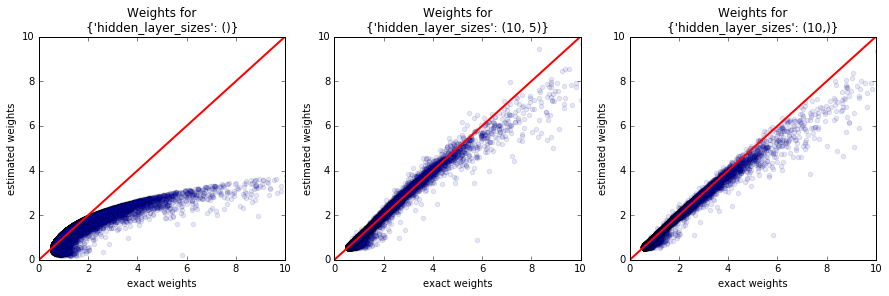

In [7]:
base_nn = MLPClassifier(
    tol=1e-05, activation="logistic", solver='lbfgs',
    random_state=42, max_iter=100)
nn_params = [{'hidden_layer_sizes': ()}, 
             {'hidden_layer_sizes': (10, 5)},
             {'hidden_layer_sizes': (10, )}]
reconstruct_ratio_using_estimated_pdfs(
    base_nn, nn_params, add_variation=True,
    with_linear_transformation=True, verbose=False)

### Let's now check how calibration of the classifier output influences reweighting.

Take the same configuration from the [notebook](https://github.com/cranmer/carl-notebooks/blob/master/reweighing-high-dimensional-data.ipynb). Also, the same samples are generated.

In [8]:
base_nn = MLPClassifier(tol=1e-05, activation="logistic", learning_rate_init=1e-5, solver='lbfgs',
                        learning_rate="constant", random_state=1, hidden_layer_sizes=(10, 10),
                        max_iter=75)
nn_params = [{'solver': 'lbfgs'}]

cross_validation = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=1)
base_nn_calibrated = CalibratedClassifierCV(base_nn, cv=cross_validation,
                                            method="kde", bins=20)
nn_params_calib = [{'method': 'histogram'}, {'method': 'isotonic'}, {'method': 'kde'}]

#### without calibration

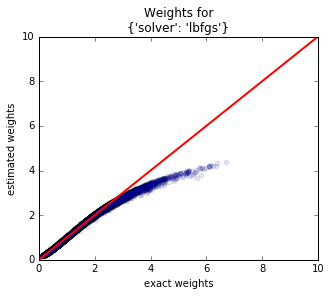

In [9]:
reconstruct_ratio_using_estimated_pdfs(
    base_nn, nn_params,
    with_linear_transformation=True, verbose=False)

#### with calibration

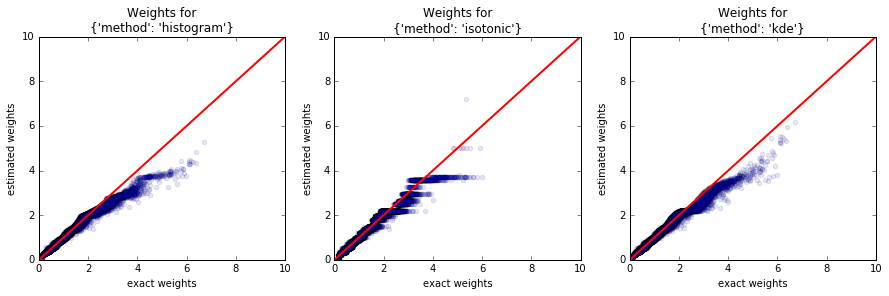

In [10]:
reconstruct_ratio_using_estimated_pdfs(
    base_nn_calibrated, nn_params_calib,
    with_linear_transformation=True, verbose=False)

#### Summary: 

Calibration is also some sort of classification model, but very simple. It is applied to obtained probabilities and could decrease the bias, but the same deviation from the diagonal (bias) stays almost untouched in this example. Calibration can be considered as tuning of more complex classification model.

## 3. BDT reweighter tuning


* number of estimators
* learning rate
* max depth
* regularization in the case of "blow up"

As soon as BDT Reweighter is boosting algorithm, the role of parameters is the same as in Gradient Boosting.

### Vary number of estimators in the ensemble

For small number of trees the ensemble is not able to reconstruct the decison rule (weights) precisely, but with increasing number of trees this rule approximation becomes better.

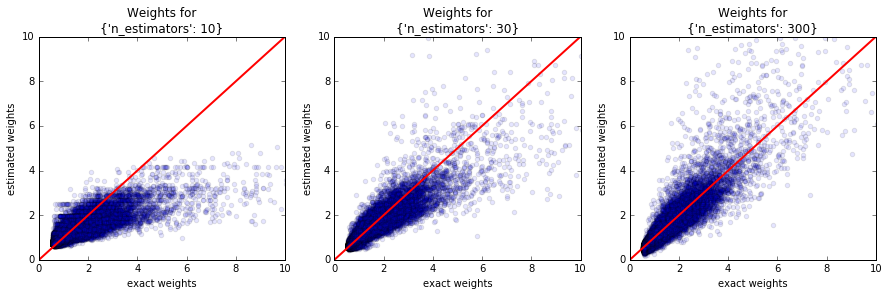

In [11]:
base_gb_reweighter = GBReweighter()
gbrw_params = [{'n_estimators': 10}, {'n_estimators': 30}, 
               {'n_estimators': 300}]
reconstruct_weights_by_GBreweighter(
    base_gb_reweighter, gbrw_params, add_variation=True,
    with_linear_transformation=True, verbose=False)

The small "slope" of the weights on scatter plot is a clear sign of the underfitting, which also can be seen in the [notebook](https://github.com/cranmer/carl-notebooks/blob/master/reweighing-high-dimensional-data.ipynb) for BDT reweighter example 

The following tuning provides the same results as carl approach:

`reweight.GBReweighter(n_estimators=3000, learning_rate=0.1, max_depth=1, min_samples_leaf=1000, 
                       gb_args={'subsample': 0.3, 'random_state': 42})`

### Vary learning rate

Learning rate (a.k.a. shrinkage, eta) helps to decrease variance. Let's check this.

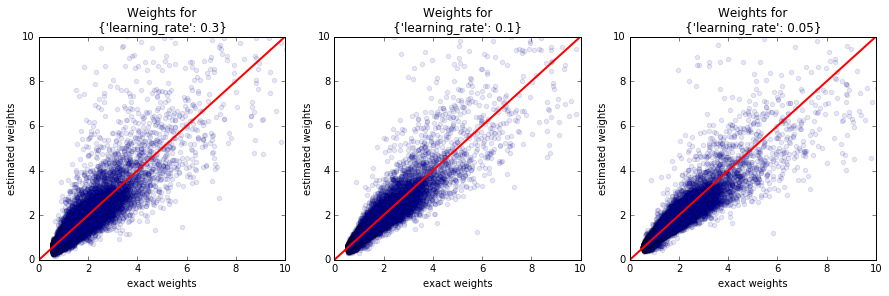

In [12]:
base_gb_reweighter = GBReweighter(n_estimators=300)
gbrw_params = [{'learning_rate': 0.3}, 
               {'learning_rate': 0.1}, 
               {'learning_rate': 0.05}]
reconstruct_weights_by_GBreweighter(
    base_gb_reweighter, gbrw_params, add_variation=True,
    with_linear_transformation=True, verbose=False)

### Vary depth of trees

This parameter corresponds to the complexity of the set of functions which are used as an approximation of the true decision rule. 

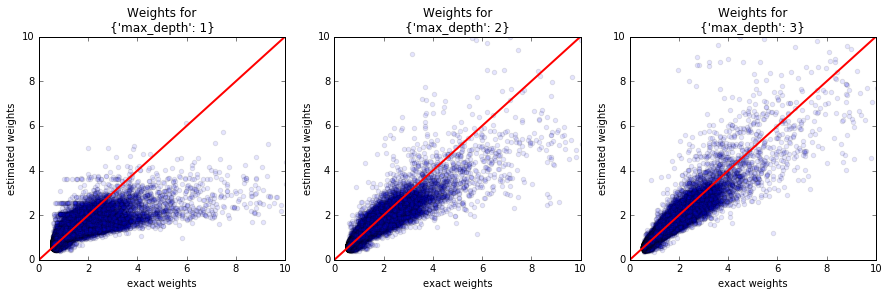

In [13]:
base_gb_reweighter = GBReweighter(n_estimators=300, learning_rate=0.05)
gbrw_params = [{'max_depth': 1}, 
               {'max_depth': 2}, 
               {'max_depth': 3}]
reconstruct_weights_by_GBreweighter(
    base_gb_reweighter, gbrw_params, add_variation=True,
    with_linear_transformation=True, verbose=False)

There are other parameters which influence the BDT reweighter and GB training process, like

* randomized samples for each tree in the ensemble (`subsample`): allows to construct very different trees in the ensemble; variance increases in this case, however, learning rate decresing and number of estimators increasing control this variance.
* randomized set of features for each tree in the ensemble (`max_features`): for the same purposes as `subsample`.
* number of samples in the leaf `min_samples_leaf`: allows to control statistics on which prediction estimate is computed.


### Bias for BDT reweighter

Good news: BDT reweighter solves directly reweighting problem, that is why bias should not appear this reweighting that is not observed during experiments.

### Regularization in case of "blow up", [issue in `hep_ml`](https://github.com/arogozhnikov/hep_ml/issues/39)

Let's generate the following samples with three independent Gaussian variables and take linear transformation ot them.

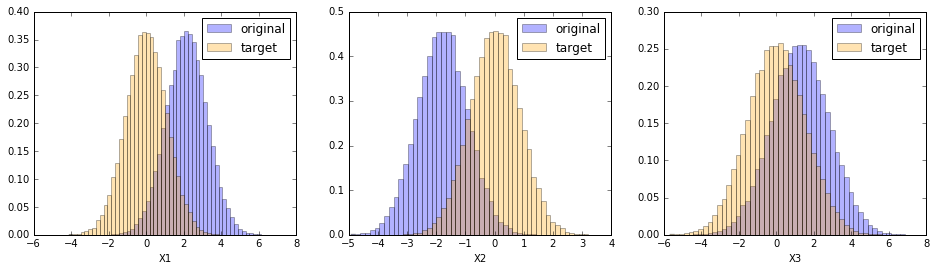

Exact weights are used (inf weights are set to 1)


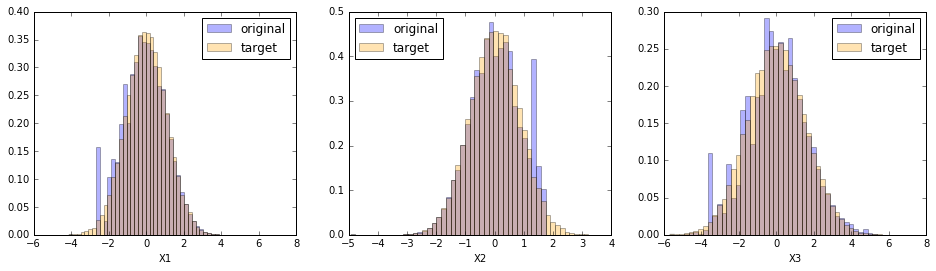

weights  [  0.07132406   0.07132406   0.07132406 ...,  22.04893375  22.04893375
  22.04893375]


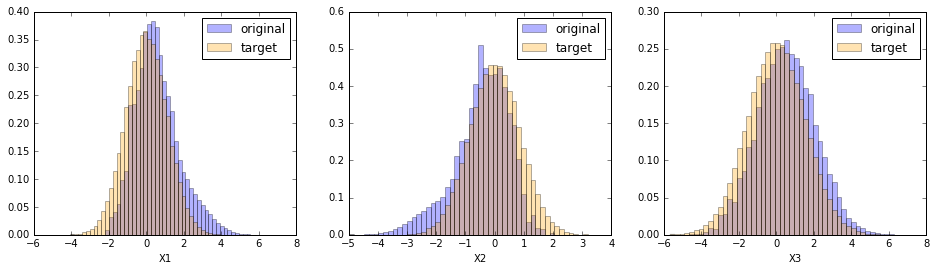

weights  [  2.26464924e-02   2.26464924e-02   2.26464924e-02 ...,   5.37206485e+01
   3.03457379e+04   3.03457379e+04]


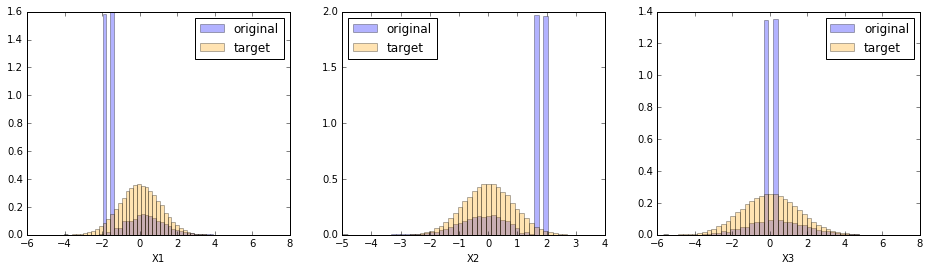

weights  [  7.47972569e-03   7.47972569e-03   7.47972569e-03 ...,   6.74304788e+01
   1.45787306e+06   1.45787306e+06]


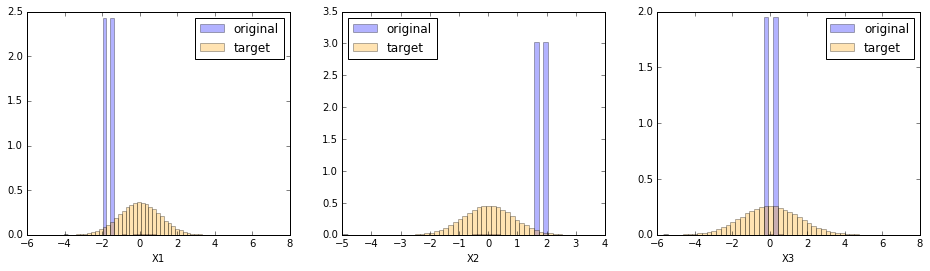

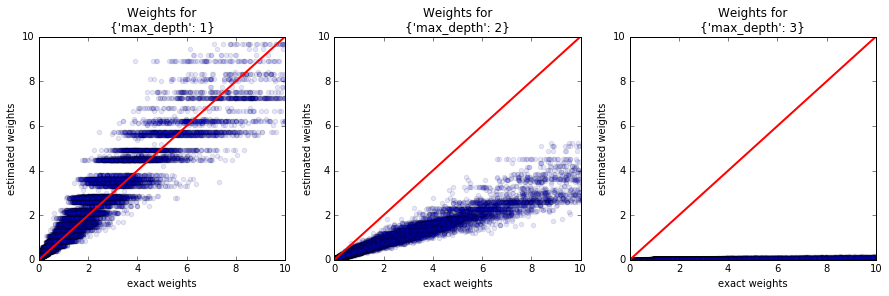

In [14]:
base_gb_reweighter = GBReweighter(n_estimators=30, learning_rate=0.1)

gbrw_params = [{'max_depth': 1}, 
               {'max_depth': 2}, 
               {'max_depth': 3}]
reconstruct_weights_by_GBreweighter_with_blow_up(
    base_gb_reweighter, gbrw_params)

For regions with very few original samples decision tree can build a leaf with samples only from target distribution  and 0 (exactly zero) from original. This does not affect train weights but huge weights appear on the test samples what demonstrated in the above example.

### To prevent overfittting and "blow up":
* decrease learning rate
* decrease tree complexity
* decrease subsample
* increase min samples in a leaf

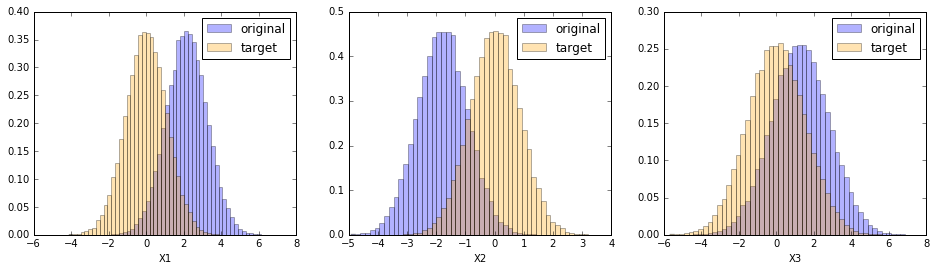

Exact weights are used (inf weights are set to 1)


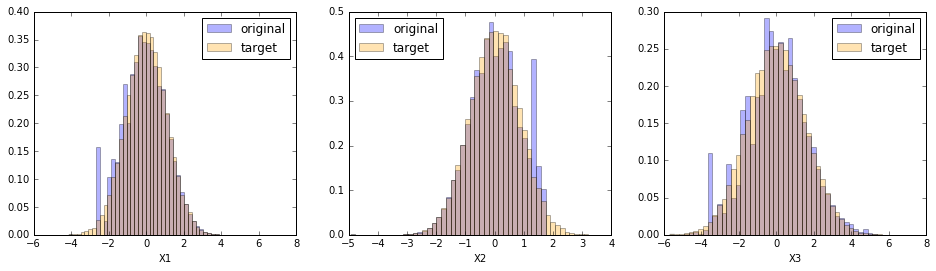

weights  [  0.0631694    0.0631694    0.0631694  ...,  17.76660837  17.76660837
  17.76660837]


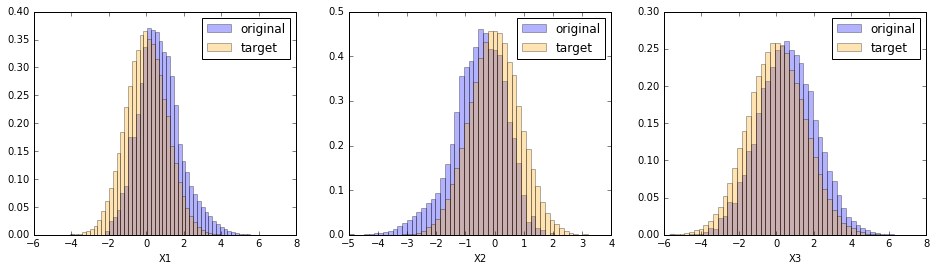

weights  [  1.84066644e-03   1.84066644e-03   1.84066644e-03 ...,   1.12384799e+02
   1.15914441e+02   1.15914441e+02]


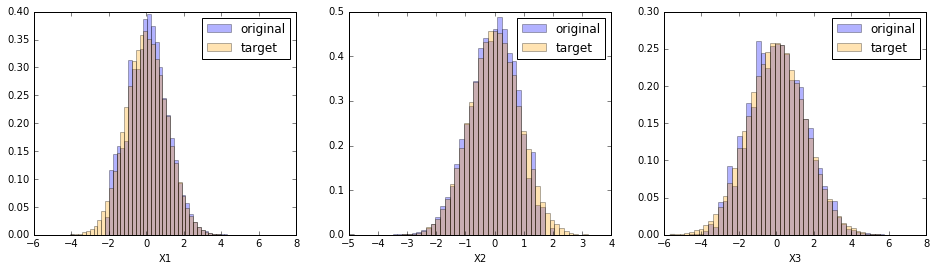

weights  [  3.37789448e-03   3.37789448e-03   3.37789448e-03 ...,   9.92210732e+01
   1.00907713e+02   1.00907713e+02]


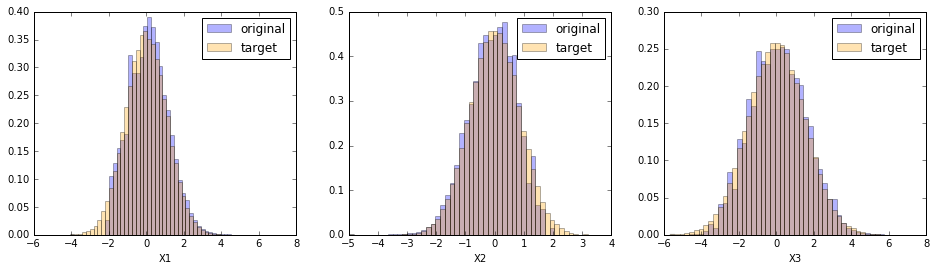

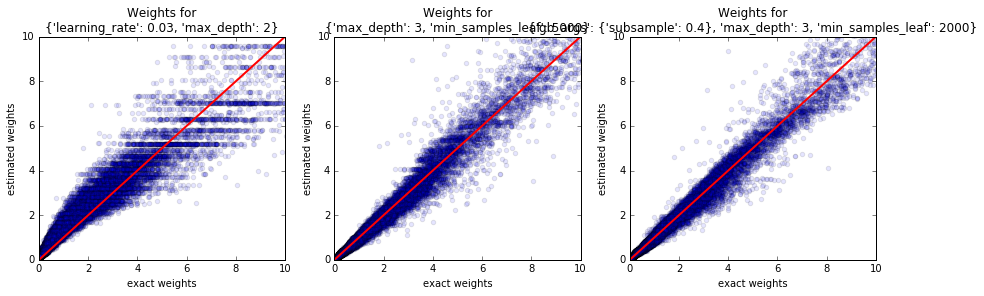

In [15]:
base_gb_reweighter = GBReweighter(
    n_estimators=50, learning_rate=0.1, 
    min_samples_leaf=200, gb_args={'subsample': 1.})

gbrw_params = [{'max_depth': 2, 'learning_rate': 0.03}, 
               {'max_depth': 3, 'min_samples_leaf': 5000},
               {'max_depth': 3, 'min_samples_leaf': 2000,
                'gb_args': {'subsample': 0.4}}]
reconstruct_weights_by_GBreweighter_with_blow_up(
    base_gb_reweighter, gbrw_params)

It is obvious that we cannot reweight regions with zero original samples to some target distribution even if target and original distributions are known due to limited statistics. Thus in practice for this kind of samples we should *cut off regions* with target samples and zero original samples to avoid poor-defined reweighting problem.

## 4. sPlot data and MC reweighting

In practice we need to reweight **simulation** (Monte Carlo, MC) samples to **sPlot data**, where **negative weights** appear in the data after sPlot procedure.

Let's see how BDT reweighter approach and calibrated density ratio approach work for this kind of reweighting problem:

* target samples emulate real data with sPlot weights, called sWeights (sWeights can be negative!)
* original samples emulate Monte Carlo samples.

#### read prepared samples for Monte Carlo and sPlot data

In [16]:
mc_samples = pandas.read_csv('datasets/mc.csv').values
rd_samples = pandas.read_csv('datasets/rd.csv')

rd_weight = rd_samples['sWeight'].values
mc_weight = numpy.ones(len(mc_samples))
rd_samples = rd_samples.drop('sWeight', axis=1).values

In [17]:
len(rd_samples), len(mc_samples)

(500000, 500000)

#### sWeights histogram

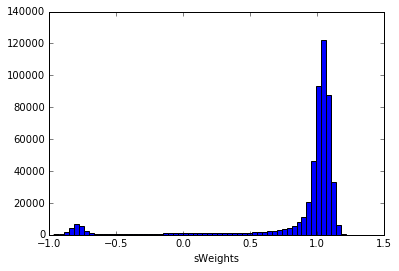

In [18]:
plt.hist(rd_weight, bins=60);
plt.xlabel('sWeights')

#### plot distributions with sPlot weights (target) and without them (original)

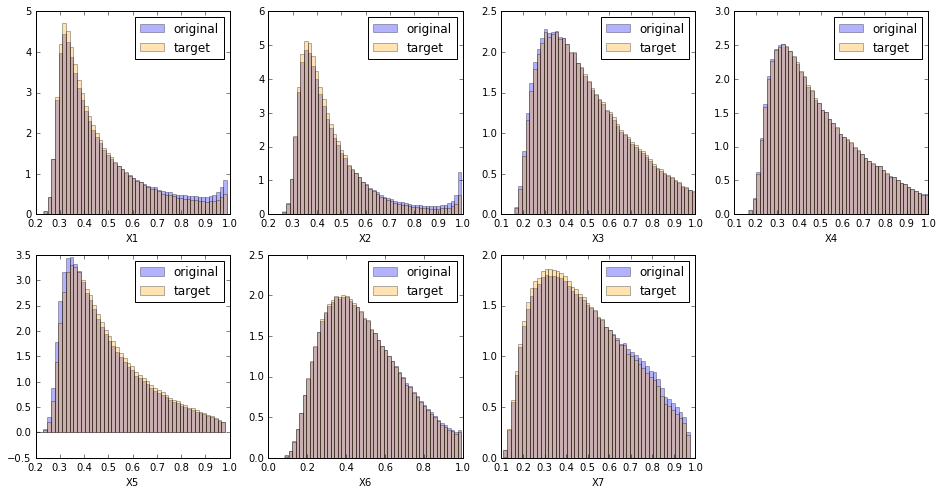

In [19]:
draw_distributions(
    original=rd_samples, target=rd_samples, 
    original_weights=numpy.ones(len(rd_samples)), target_weights=rd_weight)

We see that sWeights change target distribution.

#### compare 1d projections for Monte Carlo samples and sPlot data

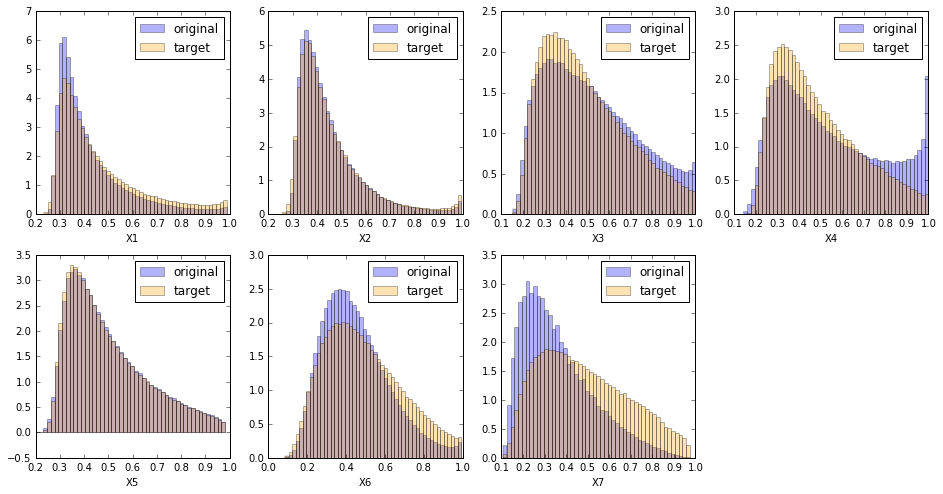

In [20]:
draw_distributions(
    original=mc_samples, target=rd_samples, 
    original_weights=mc_weight, target_weights=rd_weight)

#### divide into train/test for correct checks

In [21]:
mc_samples_train, mc_samples_test = train_test_split(mc_samples, train_size=0.51, random_state=42)
rd_samples_train, rd_samples_test, rd_weight_train, rd_weight_test = train_test_split(rd_samples, rd_weight,
                                                                                      train_size=0.51, random_state=42)
mc_weight_train, mc_weight_test = (numpy.ones(len(mc_samples_train)), numpy.ones(len(mc_samples_test)))

#### compare original and target distributions using ML

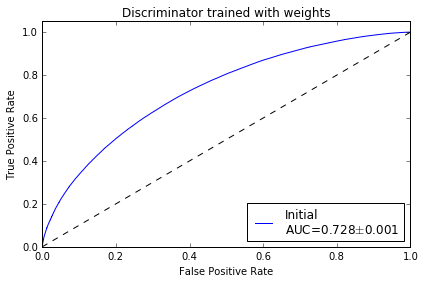

In [22]:
plot_roc(*check_reweighting_by_ML_gb(
        mc_samples_test, rd_samples_test, 
        mc_weight_test, rd_weight_test, n_iterations=10), 
    name='Initial')

### BDT reweighter on MC vs sPlot data samples

In [23]:
gb_reweighter = GBReweighter(
    n_estimators=200, learning_rate=0.15, max_depth=4,
    min_samples_leaf=1000, 
    gb_args={'subsample': 0.6, 'random_state': 42})
gb_reweighter.fit(
    mc_samples_train, rd_samples_train, 
    mc_weight_train, rd_weight_train)
mc_weight_test_gb = gb_reweighter.predict_weights(mc_samples_test)

#### plot holdout distributions after BDT reweighter (data again are sPlotted)

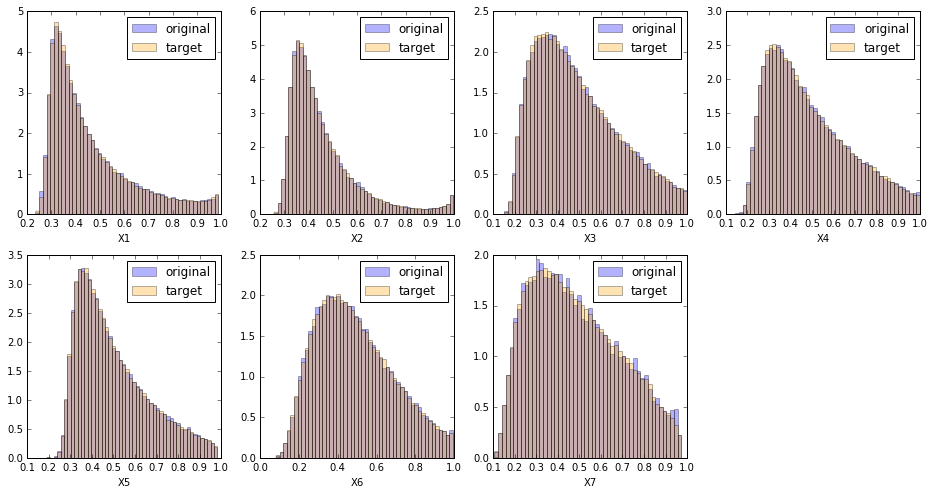

In [24]:
draw_distributions(
    mc_samples_test, rd_samples_test, mc_weight_test_gb, rd_weight_test)

#### compare multidimentional distributions after reweighting using ML

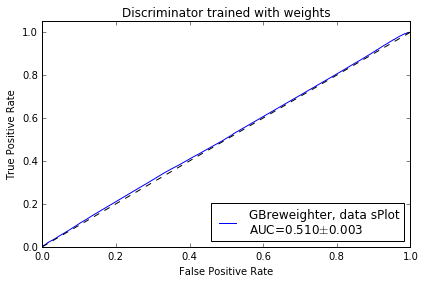

In [25]:
plot_roc(*check_reweighting_by_ML_gb(
        mc_samples_test, rd_samples_test, 
        mc_weight_test_gb, rd_weight_test, n_iterations=10), 
    name='GBreweighter, data sPlot')

### Calibrated Discriminative Classifiers Approach

Unfortunately, **`sklearn.neural_network`** does not supports sample weights at all. 
Also **`CalibratedClassifierCV`** does not support samples weights during **`kde`** calibration. 

Let's try to run calibrated ration approach using Gradient Boosting and isotonic calibration, which both support weights.

In [26]:
# define ration fit function
def fit_ratio(classifier, original, target, original_weights, target_weights):
    ratio = ClassifierRatio(base_estimator=classifier, random_state=42)

    # reformat X0 and X1 into training data
    X = numpy.vstack((original, target))
    y = numpy.array([1] * original.shape[0] + [0] * target.shape[0])
    w = numpy.concatenate([original_weights, target_weights])

    # fit the ration
    ratio.fit(X, y, sample_weight=w)
    return ratio

def test_models(models, n_iterations=1):
    for name, model in models.items():
        mc_weight_test_carl = fit_ratio(model, mc_samples_train, rd_samples_train,
                                        mc_weight_train, rd_weight_train).predict(mc_samples_test, log=False)
        mc_weight_test_carl[numpy.isinf(mc_weight_test_carl)] = 0.
        plot_roc(*check_reweighting_by_ML_gb(mc_samples_test, rd_samples_test, 
                                     mc_weight_test_carl, rd_weight_test, n_iterations=n_iterations), 
                 name=name)

#### define several models of the ratio
We define Gradient Boosting models which support sample weights.

In [27]:
# classification models
classifier_gb = GradientBoostingClassifier(
    n_estimators=100, min_samples_leaf=50, learning_rate=0.1, 
    subsample=0.7, max_features=0.9, max_depth=6, random_state=11)
cross_validation = StratifiedShuffleSplit(
    n_splits=1, test_size=0.5, random_state=1)

carl_gb_calib_hist = CalibratedClassifierCV(
    classifier_gb, cv=cross_validation, method="histogram", bins=50)
carl_gb_calib = CalibratedClassifierCV(
    classifier_gb, cv=cross_validation, method="isotonic")

In [28]:
# regression models
regressor_gb = GradientBoostingRegressor(
    n_estimators=100, min_samples_leaf=50, learning_rate=0.1, 
    subsample=0.7, max_features=0.9, max_depth=6, random_state=11)
carl_gbreg_calib_hist = CalibratedClassifierCV(
    regressor_gb, cv=cross_validation, method="histogram", bins=50)
carl_gbreg_calib = CalibratedClassifierCV(
    regressor_gb, cv=cross_validation, method="isotonic")

With comparison to BDT reweighter parameters are different, because we optimize quality of classification, 
leaving the correction of found probabilities to calibration.

`min_sample_leaf=1000` is set for BDT reweighter (1000 samples are used for weight estimation in a leaf) for more stable weight estimate while for Gradient Boosting `min_sample_leaf=50` is a good approximation in practice during classes discrimination.

Again, remember that reweighter and classifier/regressor solve different problems.

#### Let's test classification models

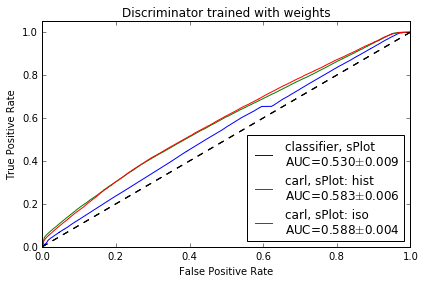

In [29]:
test_models({'carl, sPlot: iso': carl_gb_calib, 
             'carl, sPlot: hist': carl_gb_calib_hist,
             'classifier, sPlot': classifier_gb}, n_iterations=10)

#### Test regression models

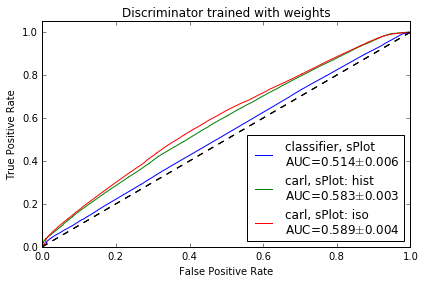

In [30]:
test_models({'carl, sPlot: iso': carl_gbreg_calib, 
             'carl, sPlot: hist': carl_gbreg_calib_hist,
             'classifier, sPlot': regressor_gb}, n_iterations=10)

#### Summary:

Negative weights can break optimization procedure during classifier training and calibration.

Often MSE $\mathcal{L}=\sum_i w_i (y_i - \hat{y}_i)^2$ or logistic loss $\mathcal{L}=\sum_i w_i y_i \log{p_i} + w_i(1 - y_i)  \log{(1 - p_i)}$ are optimized during fitting. Negative weights break the convexity and boundedness of the loss function, making the whole optimization unstable. This contribution can be negligible, however, in practice, we observe this contribution breaks normal optimization process.

* Negative weights can prevent classifier training and as a result ratio is defined poorly.
* Naive classifier calibration frequently worsens the weights reconstruction.

## Thank you for attention!